In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy import optimize
from sklearn.cluster import DBSCAN



In [2]:
def twoPointAngle(theta1, theta2, phi1, phi2):
    acosangle = np.sin(np.deg2rad(theta1)) * np.sin(np.deg2rad(theta2)) * np.cos(
        np.deg2rad(phi1 - phi2)
    ) + np.cos(np.deg2rad(theta1)) * np.cos(np.deg2rad(theta2))
    acosangle[acosangle > 1] = 1
    acosangle[acosangle < -1] = -1
    return np.rad2deg(np.arccos(acosangle))


def similarity(x):
    distance = np.zeros([x.shape[0], x.shape[0]])
    for i in range(x.shape[0]):
        # print(i)
        distance[i] = twoPointAngle(x[i, 0], x[:, 0], x[i, 1], x[:, 1])
    return distance

In [3]:
pix = np.load("/home2/hky/github/Gamma_Energy/AllSky_withCR/Exptdatacut/pixlist.npy")

In [34]:
NSIDE = 2**10
X = np.rad2deg(hp.pix2ang(NSIDE, pix)).T
distance = similarity(X)
model = DBSCAN(eps=0.5, min_samples=3, metric="precomputed")
yhat = model.fit_predict(distance)
sourcelist = np.unique(yhat)

In [35]:
sourcelist

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138])

In [36]:
Ra,Dec=hp.pix2ang(NSIDE, pix,lonlat=True)

In [37]:
for source in sourcelist:
    pixneed = pix[yhat==source]
    Ra,Dec=hp.pix2ang(NSIDE, pixneed,lonlat=True)
    Ra = np.mean(Ra)
    Dec = np.mean(Dec)
    print(Dec,Ra)

33.423365368367215 182.08432837670344
61.000261506978006 336.8988411514418
55.4988103178868 79.83647374896027
52.705425349843985 223.89697049354223
42.229031225756664 202.99560737130668
41.38364948398075 307.80430100066974
39.765642167765016 253.60107421875
36.67033882420642 305.0410420185811
28.762295634579736 298.81141340228874
22.012867992544468 83.9716663099315
6.251064968236748 287.06048346185065
4.90952531559457 311.57626065340907
2.0614004642054256 284.310791015625
-3.6657812548832656 280.9446364182692
-6.119867168501421 279.66012137276783
-13.797616130212088 276.4894584760274
53.748536688666945 185.44001772875012
46.01621911317716 160.93821710804062
44.454961984403795 34.17605059639124
39.370431600223846 341.865234375
39.18580790861313 1.142578125
17.572427507137128 98.60115840517241
7.790248514194798 23.343749999999996
-0.2680568992893031 282.2740279796512
59.01455703269035 333.22160338290945
53.18026139512551 275.634745751088
52.31947555165599 200.7961769380187
46.79298732821

In [519]:
def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def top_hat(b, radius):
    return np.where(abs(b) <= radius, 1, 0)


def twoPointAngle(theta1, theta2, phi1, phi2):
    acosangle = np.sin(np.deg2rad(theta1)) * np.sin(np.deg2rad(theta2)) * np.cos(
        np.deg2rad(phi1 - phi2)
    ) + np.cos(np.deg2rad(theta1)) * np.cos(np.deg2rad(theta2))
    acosangle[acosangle > 1] = 1
    acosangle[acosangle < -1] = -1
    return np.rad2deg(np.arccos(acosangle))


def similarity(x):
    distance = np.zeros([x.shape[0], x.shape[0]])
    for i in range(x.shape[0]):
        # print(i)
        distance[i] = twoPointAngle(x[i, 0], x[:, 0], x[i, 1], x[:, 1])
    return distance


In [5]:
NSIDE = 2**10
NPIX = hp.nside2npix(NSIDE)
reso = 1
drawdeg = 3
binsnumber = int(drawdeg * 60 / reso * 2)


In [7]:
def LIMA(alpha, Non, Noff):
    sig = np.sqrt(2) * np.sqrt(
        Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
        + Noff * np.log((1 + alpha) * Noff / (Non + Noff))
    )
    if type(sig) is np.ndarray:
        sig[np.where((Non - Noff * alpha) < 0)] = -sig[
            np.where((Non - Noff * alpha) < 0)
        ]
        sig[np.isnan(sig)] = 0

    else:
        if (Non - Noff * alpha) < 0:
            sig = -sig
        if np.isnan(sig):
            sig = 0
    return sig


In [8]:
DataPath = (
    "/home2/hky/github/Gamma_Energy/Exptdata/ALLsky_23_05_17_isgammacuted_E_Ra_Dec_new"
)
Exptdata = dict()
for root, dirs, files in os.walk(DataPath):
    for name in files:
        Exptdata_tmp = np.load(os.path.join(root, name))
        for key in Exptdata_tmp:
            if key not in Exptdata.keys():
                Exptdata[key] = list()
            Exptdata[key].append(Exptdata_tmp[key])
for key in Exptdata.keys():
    Exptdata[key] = np.concatenate(Exptdata[key])
Exptdata["sumpfcut"] = np.zeros_like(Exptdata["sumpf"])

In [451]:
def getsigma_Allsky(cut, sumpfbins, Exptdata):
    Exptdata["sumpfcut"][Exptdata["sumpf"] < sumpfbins[0]] = 1
    Exptdata["sumpfcut"][Exptdata["sumpf"] > sumpfbins[-1]] = 0.99
    for i in range(len(cut)):
        Exptdata["sumpfcut"][
            (Exptdata["sumpf"] > sumpfbins[i]) & (Exptdata["sumpf"] < sumpfbins[i + 1])
        ] = cut[i]
    hpmap_All = np.zeros(NPIX)
    hpmap_Background = np.zeros(NPIX)
    need = np.where(Exptdata["isgamma"] > Exptdata["sumpfcut"])
    np.add.at(
        hpmap_All,
        hp.ang2pix(
            NSIDE,
            Exptdata["Ra"][need],
            Exptdata["Dec"][need],
            lonlat=True,
        ),
        1,
    )
    for i in range(20):
        np.add.at(
            hpmap_Background,
            hp.ang2pix(
                NSIDE,
                Exptdata[f"RaOff_{i}"][need],
                Exptdata[f"DecOff_{i}"][need],
                lonlat=True,
            ),
            1,
        )
    return hpmap_All, hpmap_Background


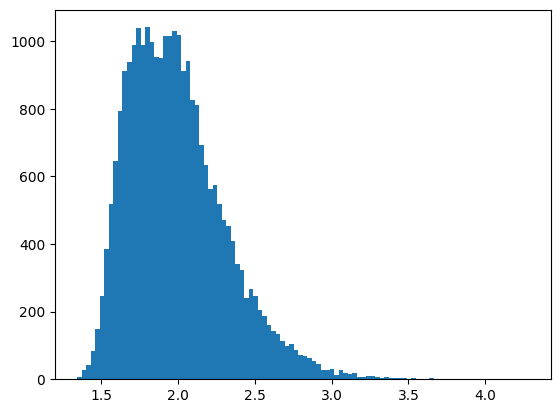

In [481]:
plt.hist(np.log10(Exptdata["energy"][(Exptdata["sumpf"]>100)&(Exptdata["isgamma"]>0.99)]),bins=100)
plt.show()

In [511]:
sumpfbins = np.logspace(2, 4.8, 16)
# cut0 = np.array(
#     [0.11, 0.21, 0.21, 0.21, 0.66, 0.76, 0.96, 0.98, 0.99, 0.99, 0.99, 0.99]
# )
cut0 = np.full(len(sumpfbins)-1,0.8)
# cut0[0]=0.8
smoothangle = 1
cut = cut0


In [512]:
hpmap_All, hpmap_Background = getsigma_Allsky(cut0, sumpfbins, Exptdata)

In [513]:
tst_map = np.zeros(NPIX)
pix = hp.ang2pix(NSIDE, np.pi/2, 0)
tst_map[pix] = 100

b = np.linspace(0,np.pi,100000)
bw = top_hat(b, np.radians(smoothangle))
beam = hp.sphtfunc.beam2bl(bw, b, NSIDE*3)
tst_map_smoothed = hp.smoothing(tst_map,beam_window=beam)

hpmap_All_smoothed2 = hp.smoothing(hpmap_All, beam_window=beam)*tst_map[pix]/np.mean(tst_map_smoothed[hp.query_disc(NSIDE,hp.pix2vec(NSIDE,pix),np.radians(smoothangle))])
hpmap_Background_smoothed2 = hp.smoothing(hpmap_Background, beam_window=beam)*tst_map[pix]/np.mean(tst_map_smoothed[hp.query_disc(NSIDE,hp.pix2vec(NSIDE,pix),np.radians(smoothangle))])

In [514]:
sigma = LIMA(0.05,hpmap_All_smoothed2,hpmap_Background_smoothed2)

/tmp/ipykernel_409110/2700012164.py:3: RuntimeWarning: invalid value encountered in log
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_409110/2700012164.py:4: RuntimeWarning: invalid value encountered in log
  + Noff * np.log((1 + alpha) * Noff / (Non + Noff))
/tmp/ipykernel_409110/2700012164.py:2: RuntimeWarning: invalid value encountered in sqrt
  sig = np.sqrt(2) * np.sqrt(


In [517]:
from sklearn.cluster import DBSCAN


In [533]:
pixneed = np.where(sigma > 4)[0]

In [546]:
X = np.rad2deg(hp.pix2ang(NSIDE, pixneed)).T
distance = similarity(X)
model = DBSCAN(eps=1, min_samples=3, metric="precomputed")
yhat = model.fit_predict(distance)

In [547]:
sourcelist = np.unique(yhat)[1:]

In [529]:
source_number = 1
pix = pixneed[yhat == source_number][
                                np.argmax(sigma[pixneed][yhat == source_number])
                            ]

In [531]:
hp.pix2ang(NSIDE,pix,lonlat=True)

(307.7490234375, 41.61044308863079)

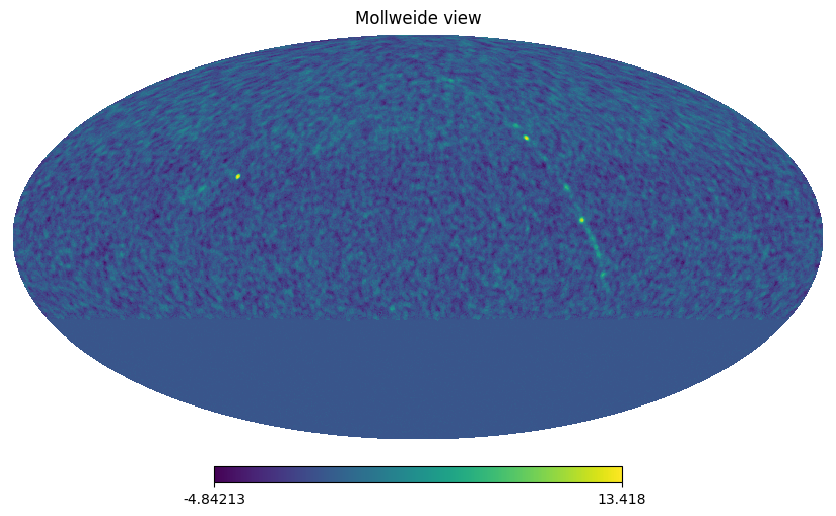

In [515]:
hp.mollview(sigma)

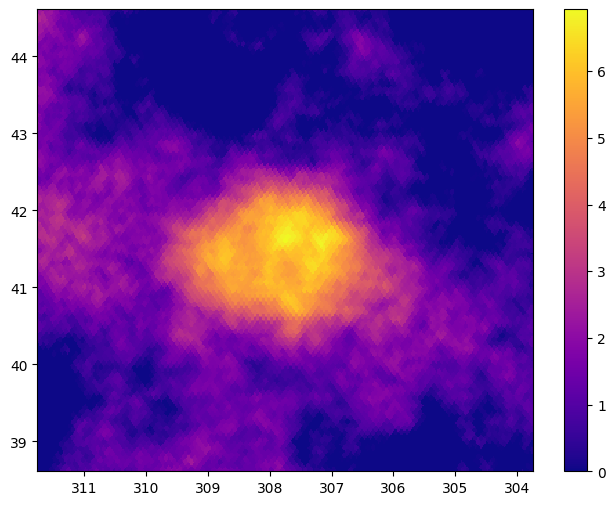

In [532]:
Ra = 307.7490234375
Dec = 41.61044308863079
sigma_tmp = hp.gnomview(
    sigma,
    rot=[Ra, Dec],
    xsize=drawdeg * 60 / reso * 2,
    reso=reso,
    return_projected_map=True,
    no_plot=True,
)
sigma_inverse = np.zeros_like(sigma_tmp)
for i in range(sigma_tmp.shape[0]):
    sigma_inverse[:, i] = sigma_tmp[:, sigma_tmp.shape[0] - 1 - i]
fig, ax = plt.subplots(figsize=(8, 6))
c = ax.pcolormesh(
    np.linspace(
        Ra - drawdeg / np.cos(np.deg2rad(Dec)),
        Ra + drawdeg / np.cos(np.deg2rad(Dec)),
        binsnumber,
    ),
    np.linspace(
        Dec - drawdeg,
        Dec + drawdeg,
        binsnumber,
    ),
    sigma_inverse,
    cmap="plasma",
    vmin=0,
)
Ra_min = Ra - drawdeg / np.cos(np.deg2rad(Dec))
Ra_max = Ra + drawdeg / np.cos(np.deg2rad(Dec))
Dec_min = Dec - drawdeg
Dec_max = Dec + drawdeg
fig.colorbar(c, orientation="vertical")
ax.set_xlim(
    Ra - drawdeg / np.cos(np.deg2rad(Dec)),
    Ra + drawdeg / np.cos(np.deg2rad(Dec)),
)
ax.set_ylim(Dec - drawdeg, Dec + drawdeg)
ax.invert_xaxis()

In [ ]:
def getExptOn(Exptdata, Ra, Dec, Energymin, Energymax):
    ExptOn_cuted = np.where(
        (Exptdata["Ra"] > Ra - 4 / np.cos(np.deg2rad(Dec)))
        & (Exptdata["Ra"] < Ra + 4 / np.cos(np.deg2rad(Dec)))
        & (Exptdata["Dec"] > Dec - 4)
        & (Exptdata["Dec"] < Dec + 4)
        & (Exptdata["energy"] > Energymin)
        & (Exptdata["energy"] < Energymax)
    )
    ExptOn_Ra = Exptdata["Ra"][ExptOn_cuted]
    ExptOn_Dec = Exptdata["Dec"][ExptOn_cuted]
    ExptOn_isgamma = Exptdata["isgamma"][ExptOn_cuted]
    ExptOn_sumpf = Exptdata["sumpf"][ExptOn_cuted]
    return ExptOn_Ra, ExptOn_Dec, ExptOn_isgamma, ExptOn_sumpf


def getExptOff(Exptdata, Ra, Dec, Energymin, Energymax):
    ExptOff_Ra = list()
    ExptOff_Dec = list()
    ExptOff_isgamma = list()
    ExptOff_sumpf = list()
    for i in range(20):
        ExptOff_cuted = np.where(
            (Exptdata[f"RaOff_{i}"] > Ra - 4 / np.cos(np.deg2rad(Dec)))
            & (Exptdata[f"RaOff_{i}"] < Ra + 4 / np.cos(np.deg2rad(Dec)))
            & (Exptdata[f"DecOff_{i}"] > Dec - 4)
            & (Exptdata[f"DecOff_{i}"] < Dec + 4)
            & (Exptdata["energy"] > Energymin)
            & (Exptdata["energy"] < Energymax)
        )
        ExptOff_Ra.append(Exptdata[f"RaOff_{i}"][ExptOff_cuted])
        ExptOff_Dec.append(Exptdata[f"DecOff_{i}"][ExptOff_cuted])
        ExptOff_isgamma.append(Exptdata["isgamma"][ExptOff_cuted])
        ExptOff_sumpf.append(Exptdata["sumpf"][ExptOff_cuted])
    ExptOff_Ra = np.concatenate(ExptOff_Ra)
    ExptOff_Dec = np.concatenate(ExptOff_Dec)
    ExptOff_isgamma = np.concatenate(ExptOff_isgamma)
    ExptOff_sumpf = np.concatenate(ExptOff_sumpf)
    return ExptOff_Ra, ExptOff_Dec, ExptOff_isgamma, ExptOff_sumpf


def getExptOn_Allsky(Exptdata, Energymin, Energymax):
    ExptOn_cuted = np.where(
        (Exptdata["energy"] > Energymin) & (Exptdata["energy"] < Energymax)
    )
    ExptOn_Ra = Exptdata["Ra"][ExptOn_cuted]
    ExptOn_Dec = Exptdata["Dec"][ExptOn_cuted]
    ExptOn_isgamma = Exptdata["isgamma"][ExptOn_cuted]
    ExptOn_sumpf = Exptdata["sumpf"][ExptOn_cuted]
    return ExptOn_Ra, ExptOn_Dec, ExptOn_isgamma, ExptOn_sumpf


def getExptOff_Allsky(Exptdata, Energymin, Energymax):
    ExptOff_Ra = list()
    ExptOff_Dec = list()
    ExptOff_isgamma = list()
    ExptOff_sumpf = list()
    for i in range(20):
        ExptOff_cuted = np.where(
            (Exptdata["energy"] > Energymin) & (Exptdata["energy"] < Energymax)
        )
        ExptOff_Ra.append(Exptdata[f"RaOff_{i}"][ExptOff_cuted])
        ExptOff_Dec.append(Exptdata[f"DecOff_{i}"][ExptOff_cuted])
        ExptOff_isgamma.append(Exptdata["isgamma"][ExptOff_cuted])
        ExptOff_sumpf.append(Exptdata["sumpf"][ExptOff_cuted])
    ExptOff_Ra = np.concatenate(ExptOff_Ra)
    ExptOff_Dec = np.concatenate(ExptOff_Dec)
    ExptOff_isgamma = np.concatenate(ExptOff_isgamma)
    ExptOff_sumpf = np.concatenate(ExptOff_sumpf)
    return ExptOff_Ra, ExptOff_Dec, ExptOff_isgamma, ExptOff_sumpf


def gethpmap_All_Background(
    cut,
    ExptOn_Ra,
    ExptOn_Dec,
    ExptOn_isgamma,
    ExptOn_sumpf,
    ExptOff_Ra,
    ExptOff_Dec,
    ExptOff_isgamma,
    ExptOff_sumpf,
    sumpfbins,
):
    hpmap_All = np.zeros(NPIX)
    hpmap_Background = np.zeros(NPIX)
    ExptOn_sumpfcut = np.zeros_like(ExptOn_isgamma)
    ExptOff_sumpfcut = np.zeros_like(ExptOff_isgamma)
    ExptOn_sumpfcut[ExptOn_sumpf < sumpfbins[0]] = 1
    ExptOn_sumpfcut[ExptOn_sumpf > sumpfbins[-1]] = 0.99
    ExptOff_sumpfcut[ExptOff_sumpf < sumpfbins[0]] = 1
    ExptOff_sumpfcut[ExptOff_sumpf > sumpfbins[-1]] = 0.99
    for i in range(len(cut)):
        ExptOn_sumpfcut[
            (ExptOn_sumpf < sumpfbins[i + 1]) & (ExptOn_sumpf > sumpfbins[i])
        ] = cut[i]
        ExptOff_sumpfcut[
            (ExptOff_sumpf < sumpfbins[i + 1]) & (ExptOff_sumpf > sumpfbins[i])
        ] = cut[i]
    np.add.at(
        hpmap_All,
        hp.ang2pix(
            NSIDE,
            ExptOn_Ra[ExptOn_isgamma > ExptOn_sumpfcut],
            ExptOn_Dec[ExptOn_isgamma > ExptOn_sumpfcut],
            lonlat=True,
        ),
        1,
    )
    np.add.at(
        hpmap_Background,
        hp.ang2pix(
            NSIDE,
            ExptOff_Ra[ExptOff_isgamma > ExptOff_sumpfcut],
            ExptOff_Dec[ExptOff_isgamma > ExptOff_sumpfcut],
            lonlat=True,
        ),
        1,
    )
    return hpmap_All, hpmap_Background


def getsigma(Ra, Dec, smoothangle, hpmap_All, hpmap_Background):
    hpmap_All_smoothed = np.zeros(NPIX)
    hpmap_Background_smoothed = np.zeros(NPIX)
    for pix in hp.query_disc(NSIDE, hp.ang2vec(Ra, Dec, lonlat=True), np.deg2rad(4)):
        pixneed = hp.query_disc(NSIDE, hp.pix2vec(NSIDE, pix), np.radians(smoothangle))
        hpmap_All_smoothed[pix] = np.sum(hpmap_All[pixneed])
        hpmap_Background_smoothed[pix] = np.sum(hpmap_Background[pixneed])
    sig = LIMA(0.05, hpmap_All_smoothed, hpmap_Background_smoothed)
    return sig


def getsigma_Allsky(smoothangle, hpmap_All, hpmap_Background):
    hpmap_All_smoothed = np.zeros(NPIX)
    hpmap_Background_smoothed = np.zeros(NPIX)
    for pix in range(NPIX):
        pixneed = hp.query_disc(NSIDE, hp.pix2vec(NSIDE, pix), np.radians(smoothangle))
        hpmap_All_smoothed[pix] = np.sum(hpmap_All[pixneed])
        hpmap_Background_smoothed[pix] = np.sum(hpmap_Background[pixneed])
    sig = LIMA(0.05, hpmap_All_smoothed, hpmap_Background_smoothed)
    return sig


def getsigma_foropt(
    cut,
    sumpfbins,
    Ra,
    Dec,
    smoothangle,
    ExptOn_Ra,
    ExptOn_Dec,
    ExptOn_isgamma,
    ExptOn_sumpf,
    ExptOff_Ra,
    ExptOff_Dec,
    ExptOff_isgamma,
    ExptOff_sumpf,
):
    hpmap_All, hpmap_Background = gethpmap_All_Background(
        cut,
        ExptOn_Ra,
        ExptOn_Dec,
        ExptOn_isgamma,
        ExptOn_sumpf,
        ExptOff_Ra,
        ExptOff_Dec,
        ExptOff_isgamma,
        ExptOff_sumpf,
        sumpfbins,
    )
    sig = getsigma(Ra, Dec, smoothangle, hpmap_All, hpmap_Background)
    # print(np.max(sig))
    return -np.max(sig)


def getsigma_fordraw(
    cut,
    sumpfbins,
    Ra,
    Dec,
    smoothangle,
    ExptOn_Ra,
    ExptOn_Dec,
    ExptOn_isgamma,
    ExptOn_sumpf,
    ExptOff_Ra,
    ExptOff_Dec,
    ExptOff_isgamma,
    ExptOff_sumpf,
):
    hpmap_All, hpmap_Background = gethpmap_All_Background(
        cut,
        ExptOn_Ra,
        ExptOn_Dec,
        ExptOn_isgamma,
        ExptOn_sumpf,
        ExptOff_Ra,
        ExptOff_Dec,
        ExptOff_isgamma,
        ExptOff_sumpf,
        sumpfbins,
    )
    sig = getsigma(Ra, Dec, smoothangle, hpmap_All, hpmap_Background)
    return sig


def getsigma_Allsky_fordraw(
    cut,
    sumpfbins,
    smoothangle,
    Exptdata,
    Energymin,
    Energymax,
):
    ExptOn_Ra, ExptOn_Dec, ExptOn_isgamma, ExptOn_sumpf = getExptOn_Allsky(
        cut, sumpfbins, Exptdata, Energymin, Energymax
    )
    ExptOff_Ra, ExptOff_Dec, ExptOff_isgamma, ExptOff_sumpf = getExptOff_Allsky(
        cut, sumpfbins, Exptdata, Energymin, Energymax
    )
    hpmap_All, hpmap_Background = gethpmap_All_Background(
        cut,
        ExptOn_Ra,
        ExptOn_Dec,
        ExptOn_isgamma,
        ExptOn_sumpf,
        ExptOff_Ra,
        ExptOff_Dec,
        ExptOff_isgamma,
        ExptOff_sumpf,
        sumpfbins,
    )
    sig = getsigma_Allsky(smoothangle, hpmap_All, hpmap_Background)
    return sig


sumpfbins = np.logspace(1.6, 4, 13)
# cut0 = np.linspace(0, 0.99, 9)
# cut0 = [ 0.9  ,0.96  ,0.95 , 0.73, 0.5, 0.45,  0.64,  0.6,  0.57]
cut0 = [0.11, 0.21, 0.21, 0.21, 0.66, 0.76, 0.96, 0.98, 0.99, 0.99, 0.99, 0.99]

bounds = [(0.2, 0.99) for _ in range(12)]


In [ ]:
TeVdata = pd.read_table("/home2/hky/github/Gamma_Energy/AllSky_withCR/TeVcat.log")
Ra_TeVcat = TeVdata["Ra"].to_numpy()
Dec_TeVcat = TeVdata["Dec"].to_numpy()
for i in range(len(Ra_TeVcat)):
    Ra_TeVcat_tmp = Ra_TeVcat[i].split()
    Dec_TeVcat_tmp = Dec_TeVcat[i].split()
    Ra_TeVcat[i] = (
        float(Ra_TeVcat_tmp[0]) / 24
        + float(Ra_TeVcat_tmp[1]) / 24 / 60
        + float(Ra_TeVcat_tmp[2]) / 24 / 60 / 60
    ) * 360
    Dec_TeVcat[i] = float(Dec_TeVcat_tmp[0])
    delta_Dec_TeVcat = (
        float(Dec_TeVcat_tmp[1]) / 60 + float(Dec_TeVcat_tmp[2]) / 60 / 60
    )
    Dec_TeVcat[i] += (-1) ** (Dec_TeVcat[i] < 0) * delta_Dec_TeVcat

Ra_TeVcat = Ra_TeVcat.astype(np.float32)
Dec_TeVcat = Dec_TeVcat.astype(np.float32)
TeVname = TeVdata["Name"]
TeVtype = TeVdata["Type"]


In [ ]:
Energymin = 10
Energymax = np.inf
sigma_max = 0
smoothangle = 0.5
cut0_tmp = np.array(cut0)
cut0_tmp[1:]=1
sigam_Allsky = getsigma_Allsky_fordraw(cut0_tmp,
    sumpfbins,
    smoothangle,
    Exptdata,
    Energymin,
    Energymax)

In [ ]:
Ra = 54.5
Dec = 53
Energymin = 10
Energymax = np.inf
sigma_max = 0
smoothangle = 0.5


In [ ]:

ExptOn_Ra, ExptOn_Dec, ExptOn_isgamma, ExptOn_sumpf = getExptOn(
    Exptdata, Ra, Dec, Energymin, Energymax
)
ExptOff_Ra, ExptOff_Dec, ExptOff_isgamma, ExptOff_sumpf = getExptOff(
    Exptdata, Ra, Dec, Energymin, Energymax
)


In [ ]:
getsigma_foropt(
    cut0,
    sumpfbins,
    Ra,
    Dec,
    smoothangle,
    ExptOn_Ra,
    ExptOn_Dec,
    ExptOn_isgamma,
    ExptOn_sumpf,
    ExptOff_Ra,
    ExptOff_Dec,
    ExptOff_isgamma,
    ExptOff_sumpf,
)


In [ ]:
res = optimize.differential_evolution(getsigma_foropt, bounds,args=(
        sumpfbins,
        Ra,
        Dec,
        smoothangle,
        ExptOn_Ra,
        ExptOn_Dec,
        ExptOn_isgamma,
        ExptOn_sumpf,
        ExptOff_Ra,
        ExptOff_Dec,
        ExptOff_isgamma,
        ExptOff_sumpf,
    ),)

In [ ]:
 [ 6.752e-01  6.921e-01  9.542e-01  8.447e-01  5.020e-01  8.840e-01  6.081e-01  9.398e-01  3.776e-01]
[ 8.975e-01  9.592e-01  9.475e-01  7.330e-01  4.949e-01   4.545e-01  6.411e-01  6.015e-01  5.695e-01]

In [ ]:
res

In [ ]:
sig = getsigma_fordraw(cut0,sumpfbins,
        Ra,
        Dec,
        smoothangle,
        ExptOn_Ra,
        ExptOn_Dec,
        ExptOn_isgamma,
        ExptOn_sumpf,
        ExptOff_Ra,
        ExptOff_Dec,
        ExptOff_isgamma,
        ExptOff_sumpf,)

In [ ]:
sig = getsigma_Allsky(smoothangle, hpmap_All, hpmap_Background)

In [ ]:
# sig_copy = sig
# sig_copy[sig_copy<3.5]=0
hp.mollview(sig)
hp.graticule()

In [ ]:
# Ra = 317
# Dec = 52
sigma_tmp = hp.gnomview(
    sig,
    rot=[Ra, Dec],
    xsize=drawdeg * 60 / reso * 2,
    reso=reso,
    return_projected_map=True,
    no_plot=True,
)
sigma_inverse = np.zeros_like(sigma_tmp)
for i in range(sigma_tmp.shape[0]):
    sigma_inverse[:, i] = sigma_tmp[:, sigma_tmp.shape[0] - 1 - i]
fig, ax = plt.subplots(figsize=(8, 6))
c = ax.pcolormesh(
    np.linspace(
        Ra - drawdeg / np.cos(np.deg2rad(Dec)),
        Ra + drawdeg / np.cos(np.deg2rad(Dec)),
        binsnumber,
    ),
    np.linspace(
        Dec - drawdeg,
        Dec + drawdeg,
        binsnumber,
    ),
    sigma_inverse,
    cmap="plasma",
    vmin=0,
)
Ra_min = Ra - drawdeg / np.cos(np.deg2rad(Dec))
Ra_max = Ra + drawdeg / np.cos(np.deg2rad(Dec))
Dec_min = Dec - drawdeg
Dec_max = Dec + drawdeg
fig.colorbar(c, orientation="vertical")
ax.set_xlim(
    Ra - drawdeg / np.cos(np.deg2rad(Dec)),
    Ra + drawdeg / np.cos(np.deg2rad(Dec)),
)
ax.set_ylim(Dec - drawdeg, Dec + drawdeg)
ax.invert_xaxis()

In [ ]:
(21/24+39/24/60+23.5/24/60/60)*360

In [ ]:
res = optimize.minimize(
    getsigma_foropt,
    cut0,
    method="Nelder-Mead",
    args=(
        sumpfbins,
        Ra,
        Dec,
        smoothangle,
        ExptOn_Ra,
        ExptOn_Dec,
        ExptOn_isgamma,
        ExptOn_sumpf,
        ExptOff_Ra,
        ExptOff_Dec,
        ExptOff_isgamma,
        ExptOff_sumpf,
    ),
    options={"disp": True, "adaptive": True},
)


In [ ]:
res

In [ ]:
getsigma_foropt(
    res.x,
    sumpfbins,
    Ra,
    Dec,
    smoothangle,
    ExptOn_Ra,
    ExptOn_Dec,
    ExptOn_isgamma,
    ExptOn_sumpf,
    ExptOff_Ra,
    ExptOff_Dec,
    ExptOff_isgamma,
    ExptOff_sumpf,
)


In [ ]:
results = dict()
results["shgo"] = optimize.shgo(
    getsigma_foropt,
    bounds,
    args=(
        sumpfbins,
        Ra,
        Dec,
        smoothangle,
        ExptOn_Ra,
        ExptOn_Dec,
        ExptOn_isgamma,
        ExptOn_sumpf,
        ExptOff_Ra,
        ExptOff_Dec,
        ExptOff_isgamma,
        ExptOff_sumpf,
    ),
)


In [ ]:
Ra = 83.6
Dec = 22
Energymin = 10
Energymax = np.inf
sigma_max = 0

ExptOn_Ra, ExptOn_Dec, ExptOn_isgamma, ExptOn_sumpf = getExptOn(
    Exptdata, Ra, Dec, Energymin, Energymax
)
ExptOff_Ra, ExptOff_Dec, ExptOff_isgamma, ExptOff_sumpf = getExptOff(
    Exptdata, Ra, Dec, Energymin, Energymax
)
sumpfbins = np.logspace(1.6, 4, 25)
cut = np.linspace(0, 0.99, 24)
hpmap_All, hpmap_Background = gethpmap_All_Background(
    cut,
    ExptOn_Ra,
    ExptOn_Dec,
    ExptOn_isgamma,
    ExptOn_sumpf,
    ExptOff_Ra,
    ExptOff_Dec,
    ExptOff_isgamma,
    ExptOff_sumpf,
    sumpfbins,
)
smoothangle = 0.5
print(getsigma(Ra, Dec, smoothangle, hpmap_All, hpmap_Background))


In [ ]:
savepath = "/home2/hky/github/Gamma_Energy/AllSky_withCR/Exptdatacut/fig"
Energymin_list = [10, 10, 50, 50, 80, 100]
Energymax_list = [np.inf, 50, np.inf, 100, np.inf, np.inf]
for Tname, Ttype, Ra, Dec in zip(TeVname, TeVtype, Ra_TeVcat, Dec_TeVcat):
    for Energymin, Energymax in zip(Energymin_list, Energymax_list):
        sigma_max = 0
        
        ExptOn_Ra,ExptOn_Dec,ExptOn_isgamma,ExptOn_sumpf=getExptOn(Exptdata,Ra,Dec,Energymin,Energymax)
        ExptOff_Ra,ExptOff_Dec,ExptOff_isgamma,ExptOff_sumpf  =getExptOff(Exptdata,Ra,Dec,Energymin,Energymax)
       

        for cut in np.linspace(0.01, 0.99, 99):
            hpmap_All, hpmap_Background=gethpmap_All_Background(ExptOn_Ra,ExptOn_Dec,ExptOn_isgamma,ExptOff_Ra,ExptOff_Dec,ExptOff_isgamma,cut)
            for smoothangle in [0.3, 0.5, 0.8, 1, 1.5, 2, 3]:


        # if sigma_max > 3:
        #     hpmap_All = np.zeros(NPIX)
        #     hpmap_Background = np.zeros(NPIX)
        #     np.add.at(
        #         hpmap_All,
        #         hp.ang2pix(
        #             NSIDE,
        #             ExptOn_Ra[ExptOn_isgamma > cut_best],
        #             ExptOn_Dec[ExptOn_isgamma > cut_best],
        #             lonlat=True,
        #         ),
        #         1,
        #     )
        #     np.add.at(
        #         hpmap_Background,
        #         hp.ang2pix(
        #             NSIDE,
        #             ExptOff_Ra[ExptOff_isgamma > cut_best],
        #             ExptOff_Dec[ExptOff_isgamma > cut_best],
        #             lonlat=True,
        #         ),
        #         1,
        #     )
        #     hpmap_All_smoothed = np.zeros(NPIX)
        #     hpmap_Background_smoothed = np.zeros(NPIX)
        #     for pix in hp.query_disc(
        #         NSIDE, hp.ang2vec(Ra, Dec, lonlat=True), np.deg2rad(5)
        #     ):
        #         pixneed = hp.query_disc(
        #             NSIDE, hp.pix2vec(NSIDE, pix), np.radians(smoothanglebest)
        #         )
        #         hpmap_All_smoothed[pix] = np.sum(hpmap_All[pixneed])
        #         hpmap_Background_smoothed[pix] = np.sum(hpmap_Background[pixneed])
        #     sig = LIMA(0.05, hpmap_All_smoothed, hpmap_Background_smoothed)

        #     sigma_tmp = hp.gnomview(
        #         sig,
        #         rot=[Ra, Dec],
        #         xsize=drawdeg * 60 / reso * 2,
        #         reso=reso,
        #         return_projected_map=True,
        #         no_plot=True,
        #     )
        #     sigma_inverse = np.zeros_like(sigma_tmp)
        #     for i in range(sigma_tmp.shape[0]):
        #         sigma_inverse[:, i] = sigma_tmp[:, sigma_tmp.shape[0] - 1 - i]
        #     fig, ax = plt.subplots(figsize=(16, 9))
        #     c = ax.pcolormesh(
        #         np.linspace(
        #             Ra - drawdeg / np.cos(np.deg2rad(Dec)),
        #             Ra + drawdeg / np.cos(np.deg2rad(Dec)),
        #             binsnumber,
        #         ),
        #         np.linspace(
        #             Dec - drawdeg,
        #             Dec + drawdeg,
        #             binsnumber,
        #         ),
        #         sigma_inverse,
        #         cmap="plasma",
        #         vmin=0,
        #     )
        #     Ra_min = Ra - drawdeg / np.cos(np.deg2rad(Dec))
        #     Ra_max = Ra + drawdeg / np.cos(np.deg2rad(Dec))
        #     Dec_min = Dec - drawdeg
        #     Dec_max = Dec + drawdeg
        #     fig.colorbar(c, orientation="vertical")
        #     ax.set_xlim(
        #         Ra - drawdeg / np.cos(np.deg2rad(Dec)),
        #         Ra + drawdeg / np.cos(np.deg2rad(Dec)),
        #     )
        #     ax.set_ylim(Dec - drawdeg, Dec + drawdeg)
        #     ax.invert_xaxis()
        #     plt.show()
        #     break


In [ ]:
Ra = 284.5
Dec = 2
Energymin = 20
Energymax = np.inf
Exptdata_Crab = Exptdata["isgamma"][
    np.where(
        (Exptdata["Ra"] > Ra - 0.5)
        & (Exptdata["Ra"] < Ra + 0.5)
        & (Exptdata["Dec"] > Dec - 0.5)
        & (Exptdata["Dec"] < Dec + 0.5)
        & (Exptdata["energy"] > Energymin)
        & (Exptdata["energy"] < Energymax)
    )
]
Exptdata_Crab_background = list()
for i in range(20):
    Exptdata_Crab_background.append(
        Exptdata["isgamma"][
            np.where(
                (Exptdata[f"RaOff_{i}"] > Ra - 0.5)
                & (Exptdata[f"RaOff_{i}"] < Ra + 0.5)
                & (Exptdata[f"DecOff_{i}"] > Dec - 0.5)
                & (Exptdata[f"DecOff_{i}"] < Dec + 0.5)
                & (Exptdata["energy"] > Energymin)
                & (Exptdata["energy"] < Energymax)
            )
        ]
    )
Exptdata_Crab_background = np.concatenate(Exptdata_Crab_background)


In [ ]:
for cut in np.linspace(0.01, 0.99, 99):
    print(
        cut,
        LIMA(
            0.05,
            np.where(Exptdata_Crab > cut)[0].shape[0],
            np.where(Exptdata_Crab_background > cut)[0].shape[0],
        ),
    )


In [ ]:
energymin = 0
smoothangle = 0.5
data_need = np.where(
    (Exptdata["energy"] > energymin) & (Exptdata["isgamma"] > Exptdata["isgammacut"])
)
hpmap_All = np.zeros(NPIX)
hpmap_Background = np.zeros(NPIX)
hpmap_All_smoothed = np.zeros(NPIX)
hpmap_Background_smoothed = np.zeros(NPIX)
np.add.at(
    hpmap_All,
    hp.ang2pix(
        NSIDE,
        Exptdata["Ra"][data_need],
        Exptdata["Dec"][data_need],
        lonlat=True,
    ),
    1,
)
for i in range(20):
    np.add.at(
        hpmap_Background,
        hp.ang2pix(
            NSIDE,
            Exptdata[f"RaOff_{i}"][data_need],
            Exptdata[f"DecOff_{i}"][data_need],
            lonlat=True,
        ),
        1,
    )

# fwhm = np.deg2rad(smoothangle)
# hpmap_All_smoothed = hp.smoothing(hpmap_All, fwhm=fwhm)
# hpmap_Background_smoothed = hp.smoothing(hpmap_Background, fwhm=fwhm)

# sigma_hp = LIMA(0.05, hpmap_All_smoothed, hpmap_Background_smoothed)
# std = np.std(sigma_hp[(hpmap_All != 0)])
# std = np.std(sigma_hp[(hpmap_All != 0) & (np.abs(sigma_hp) < 5 * std)])
# sigma_hp /= std
for pix in range(NPIX):
    pixneed = hp.query_disc(NSIDE, hp.pix2vec(NSIDE, pix), np.radians(smoothangle))
    hpmap_All_smoothed[pix] = np.sum(hpmap_All[pixneed])
    hpmap_Background_smoothed[pix] = np.sum(hpmap_Background[pixneed])


In [ ]:
hp.mollview(hpmap_All)


In [ ]:
hp.mollview(hpmap_All_smoothed - hpmap_Background_smoothed / 20)


In [ ]:
plt.hist(sig[hpmap_All != 0], bins=100)
plt.yscale("log")
plt.show()


In [ ]:
hp.mollview(sig)


In [ ]:
np.max(sig)


In [ ]:
reso = 3
drawdeg = 3
binsnumber = int(drawdeg * 60 / reso * 2)
Ra = 284
Dec = 2
sigma_tmp = hp.gnomview(
    sig,
    rot=[Ra, Dec],
    xsize=drawdeg * 60 / reso * 2,
    reso=reso,
    return_projected_map=True,
    no_plot=True,
)
sigma_inverse = np.zeros_like(sigma_tmp)
for i in range(sigma_tmp.shape[0]):
    sigma_inverse[:, i] = sigma_tmp[:, sigma_tmp.shape[0] - 1 - i]
fig, ax = plt.subplots(figsize=(16, 9))
c = ax.pcolormesh(
    np.linspace(
        Ra - drawdeg / np.cos(np.deg2rad(Dec)),
        Ra + drawdeg / np.cos(np.deg2rad(Dec)),
        binsnumber,
    ),
    np.linspace(
        Dec - drawdeg,
        Dec + drawdeg,
        binsnumber,
    ),
    sigma_inverse,
    cmap="plasma",
    vmin=0,
)
Ra_min = Ra - drawdeg / np.cos(np.deg2rad(Dec))
Ra_max = Ra + drawdeg / np.cos(np.deg2rad(Dec))
Dec_min = Dec - drawdeg
Dec_max = Dec + drawdeg
fig.colorbar(c, orientation="vertical")
ax.set_xlim(
    Ra - drawdeg / np.cos(np.deg2rad(Dec)),
    Ra + drawdeg / np.cos(np.deg2rad(Dec)),
)
ax.set_ylim(Dec - drawdeg, Dec + drawdeg)
ax.invert_xaxis()
